# Initial Imports

In [6]:
import pickle
import pandas as pd
import numpy as np
import nltk
from textblob import TextBlob
import matplotlib.pyplot as plt
import math
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

Notes from class:
- add Hurricane harvey to stopword list, or change max document frequency

# Read in data from mongo & make metadata db

In [81]:
import json
from pymongo import MongoClient

client = MongoClient()
db = client.twitter
tweets_collection = db.tweets
tweets_meta = db.meta

In [82]:
def get_tweet_metadata(tweet):
    meta_dict = {}
    meta_dict['storm'] = 'Harvey'
    try: meta_dict['id']  = tweet['id']
    except: pass
    try: meta_dict['user_id']  = tweet['entities']['user_mentions'][0]['id']
    except: pass
    try: meta_dict['user_name']  = tweet['entities']['user_mentions'][0]['name']
    except: pass
    try: meta_dict['datetime'] = tweet['created_at']
    except: pass
    try: meta_dict['media'] = tweet['entities']['media'][0]['media_url']
    except: pass
    try: meta_dict['media_type'] = tweet['extended_entities']['media'][0]['type']
    except: pass
    try: meta_dict['coords'] = tweet['geo']['coordinates']
    except: pass
    try: meta_dict['text'] = tweet['text']
    except: pass
    try: 
        hashtags_text = tweet['entities']['hashtags']
        hashtags = []
        for i in hashtags_text:
            hashtags.append(i['text'])
        meta_dict['hashtags'] = hashtags
    except: pass
    try: meta_dict['followers'] = tweet['extended_entities']['media'][0]['additional_media_info']['source_user']['followers_count']
    except: pass
    try: meta_dict['following'] = tweet['extended_entities']['media'][0]['additional_media_info']['source_user']['friends_count']
    except: pass
    try: meta_dict['user_location'] = tweet['extended_entities']['media'][0]['additional_media_info']['source_user']['location']
    except: pass
    try: meta_dict['retweets'] = tweet['retweet_count']
    except: pass
    return meta_dict


In [5]:
# for tweet in tweets_collection.find():
#     meta_dict = get_tweet_metadata(tweet)
#     tweets_meta.insert_one(meta_dict)

# Read into Pandas & Clean metadata

In [83]:
cursor = tweets_meta.find()
df =  pd.DataFrame(list(cursor))

## Fix datetime

In [84]:
import time
from datetime import time
from datetime import datetime
import re

In [85]:
timestamp = []
date_out = []
weekday = []

dates = df['datetime']
for i in dates:
    date = re.sub('\+0000 ', '', i)
    datetime = datetime.strptime(date, "%a %b %d %X %Y") 
    timestamp.append(datetime)
    date_out.append(datetime.date())
    weekday.append(datetime.weekday())

In [86]:
df['timestamp'] = timestamp
df['date'] = date_out
df['weekday'] = weekday


**Note: Define working sample date here**

In [87]:
date_slice = df.iloc[150000,:]['date']
df_slice = df[df['date']== date_slice]
len(df_slice)

627137

## Text cleaning
need to remove:
    - remove retweets
    - stop words
    - non-ascii characters (maybe bring back emojis later?)
    - punctuation
    - numbers
    - URLs
    - hashtags
    - stem words
    

### remove retweets

In [88]:
df_noRT = df_slice[df_slice['text'].astype(str).str.startswith('RT') == False]
len(df_noRT)

100352

In [89]:
df_noRT.head()

,_id,coords,datetime,followers,following,hashtags,id,media,media_type,retweets,storm,text,user_id,user_location,user_name,timestamp,date,weekday
106895,5b0c59c4b7111907d85a6ece,NaN,Tue Aug 29 18:07:02 +0000 2017,NaN,NaN,[],902593451333648384,NaN,NaN,0,Harvey,And she has white tennis shoes on as First Lad...,NaN,NaN,NaN,2017-08-29 18:07:02,2017-08-29,1
106955,5b0c59c4b7111907d85a6f0a,NaN,Tue Aug 29 18:07:03 +0000 2017,NaN,NaN,[],902593455062478851,NaN,NaN,0,Harvey,@kylegriffin1 @JoaquinCastrotx I'm suprised he...,32871086.0,NaN,Kyle Griffin,2017-08-29 18:07:03,2017-08-29,1
106960,5b0c59c4b7111907d85a6f0f,NaN,Tue Aug 29 18:07:03 +0000 2017,NaN,NaN,[],902593454278139905,NaN,NaN,0,Harvey,https://t.co/KY7pgMHrWM - 'Hurricane Hawk' fli...,386270039.0,NaN,Po.st,2017-08-29 18:07:03,2017-08-29,1
106965,5b0c59c4b7111907d85a6f14,NaN,Tue Aug 29 18:07:03 +0000 2017,NaN,NaN,[],902593456094273538,NaN,NaN,0,Harvey,Wild 😐 https://t.co/Yl70aI6a9t,NaN,NaN,NaN,2017-08-29 18:07:03,2017-08-29,1
106976,5b0c59c4b7111907d85a6f1f,NaN,Tue Aug 29 18:07:05 +0000 2017,NaN,NaN,[],902593461102276608,NaN,NaN,0,Harvey,Have We Lost Our Humanity? Social Media Commen...,NaN,NaN,NaN,2017-08-29 18:07:05,2017-08-29,1


In [90]:
documents = np.asarray(df_noRT.text)

In [15]:
documents[5:16]

NameError: name 'documents' is not defined

In [92]:
import string
cleaned_docs = []
hashtags = []
for doc in documents:
    hashtag = re.compile('#[a-zA-Z0-9]*')
    match = mention.findall(doc)
    hashtags.append(match)
    doc = re.sub('@\S*', '', doc)
#     doc = re.sub('#', '', doc)
    doc = re.sub('&amp', 'and', doc)
    doc = re.sub('&amp ', 'and', doc)
    doc = re.sub('https:\S*', '', doc)
    doc = re.sub('\\n', ' ', doc)
    doc = re.sub('[0-9]', '', doc)
    exclude = set('!"$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'+'…')
    doc = ''.join(ch for ch in doc if ch not in exclude)
    cleaned_docs.append(doc)

In [93]:
cleaned_docs

['And she has white tennis shoes on as First Lady departs plane ',
 '  Im suprised he passed the opportunity to announced that the Trump co will donate  ',
 '  Hurricane Hawk flies into taxi to take refuge from Hurricane Harvey  via ',
 'Wild 😐 ',
 'Have We Lost Our Humanity Social Media Comments About Hurricane Harvey Victims Get Nasty ',
 'Abbreviated pundit roundup Climate change and Hurricane Harvey ',
 'Sorry ladies hes married ',
 'Wow ❤️ immediately cried ',
 'inject this take directly into my blood stream ',
 'Filing HVUT Form  late because of #HurricaneHarvey You can get your penalties waived Click here for more info ',
 'Charities can help today and then help to rebuild  The best charities to give to in the wake of #HurricaneHarvey ',
 'Together We Can Rebuild Houston #JoinUs  via ',
 'So many people in that area ',
 'Looking for these two men 🙏tanyasrockss photo  #HurricaneHarvey #animalsinneed #help',
 'Peep this thread for many ways to help ',
 'The funny thing about this 

In [ ]:
#parse out just hastags as list

In [19]:
from nltk.tokenize.casual import TweetTokenizer

In [20]:
s = 'Also near my house  I have idea how you captured this scene 😱 '
s1 = TweetTokenizer().tokenize(s)
print (s1)

['Also', 'near', 'my', 'house', 'I', 'have', 'idea', 'how', 'you', 'captured', 'this', 'scene', '😱']


In [41]:
len(cleaned_docs)

100352

## Create new dataframe with cleaned docs and hashtags

In [94]:
df_cleaned_docs = pd.DataFrame(columns = ['id', 'scraped_hashtags', 'parsed_hashtags', 'full_text', 'cleaned_text'])


In [95]:
df_cleaned_docs.id = df_noRT.id
df_cleaned_docs.scraped_hashtags = df_noRT.hashtags
df_cleaned_docs.parsed_hashtags = hashtags
df_cleaned_docs.full_text = df_noRT.text
df_cleaned_docs.cleaned_text = cleaned_docs


In [96]:
df_cleaned_docs

,id,scraped_hashtags,parsed_hashtags,full_text,cleaned_text
106895,902593451333648384,[],[],And she has white tennis shoes on as First Lad...,And she has white tennis shoes on as First Lad...
106955,902593455062478851,[],[],@kylegriffin1 @JoaquinCastrotx I'm suprised he...,Im suprised he passed the opportunity to ann...
106960,902593454278139905,[],[],https://t.co/KY7pgMHrWM - 'Hurricane Hawk' fli...,Hurricane Hawk flies into taxi to take refug...
106965,902593456094273538,[],[],Wild 😐 https://t.co/Yl70aI6a9t,Wild 😐
106976,902593461102276608,[],[],Have We Lost Our Humanity? Social Media Commen...,Have We Lost Our Humanity Social Media Comment...
106989,902593455196696578,[],[],Abbreviated pundit roundup: Climate change &am...,Abbreviated pundit roundup Climate change and ...
106992,902593456173748224,[],[],"Sorry ladies, he's married. https://t.co/Io3Xq...",Sorry ladies hes married
106996,902593456056532992,[],[],Wow ❤️ immediately cried https://t.co/Xs8EgkWBEM,Wow ❤️ immediately cried
106999,902593453044969473,[],[],inject this take directly into my blood stream...,inject this take directly into my blood stream
107000,902593462394118144,[HurricaneHarvey],[#HurricaneHarvey],Filing HVUT Form 2290 late because of #Hurrica...,Filing HVUT Form late because of #HurricaneHa...


In [2]:
# pickle.dump( df_cleaned_docs, open( "df_cleaned_docs_for_pickup.pkl", "wb" ) )

df_cleaned_docs = pickle.load(open("df_cleaned_docs_for_pickup.pkl", "rb"))
cleaned_docs=list(df_cleaned_docs.cleaned_text)


In [7]:
len(cleaned_docs)

100352

# Top bigrams

In [19]:
from nltk.util import ngrams
from collections import Counter
from operator import itemgetter
from nltk.corpus import stopwords

In [55]:
stop = stopwords.words('english')
stop += ['every','like','amp','may']
counter = Counter()

n = 2
for doc in cleaned_docs:
    words = TextBlob(doc).words
    words = [w for w in words if w not in stop]
    bigrams = ngrams(words, n)
    counter += Counter(bigrams)


In [45]:
for phrase, count in counter.most_common(10):
    phrase = " ".join(phrase)
    print(phrase+': '+str(count))

Hurricane Harvey: 6339
Harvey relief: 451
Harvey Relief: 399
Harvey victims: 373
Donald Trump: 338
hurricane Harvey: 317
The latest: 300
affected Hurricane: 260
relief efforts: 234
Harvey Victims: 207


In [48]:
#how many have coordinates associated
len(df_slice_noRT.coords)

100352

In [49]:
count = 0
for i in list(df_slice_noRT.coords.isnull()):
    if i is False:
        count+=1

In [50]:
count

297

## LDA

In [29]:
n_components = 10
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                ngram_range=(1,3),
                                max_features=1000,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(cleaned_docs)

lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

vocab = tf_vectorizer.get_feature_names()

In [31]:
for topic in range(n_components):
    print(f"TOPIC {topic}")
    for j in np.argsort(lda.components_,1)[topic,:10]:
        print(vocab[j])
    print()

TOPIC 0
texas handle hurricane
handle hurricane
handle hurricane harvey
hurricane harvey releasing
harvey releasing hazardous
harvey releasing
refineries damaged hurricane
obamas flood protection
obamas flood
dividing

TOPIC 1
hurricane harvey asked
crucial questions hurricane
questions hurricane
questions hurricane harvey
latest update tropical
update tropical storm
update tropical
harvey breitbart
hurricane harvey breitbart
crucial questions

TOPIC 2
hurricane harvey breitbart
harvey breitbart
obamas flood protection
obamas flood
just days hurricane
flood protection
hazardous pollutants
releasing hazardous
donald trump cheering
harvey releasing

TOPIC 3
texas handle hurricane
trump cheering
trump cheering crowd
donald trump cheering
crowd texas handle
cheering crowd texas
cheering crowd
crowd texas
hurricane harvey releasing
harvey releasing hazardous

TOPIC 4
hurricane harvey breitbart
harvey breitbart
hurricane harvey releasing
harvey releasing hazardous
harvey releasing
obamas flo

In [42]:
n_components = 10
tf_vectorizer = CountVectorizer(max_df=0.70, min_df=2,ngram_range=(1,2),max_features=100000,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(cleaned_docs)

lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

vocab = tf_vectorizer.get_feature_names()

In [43]:
for topic in range(n_components):
    print(f"TOPIC {topic}")
    for j in np.argsort(lda.components_,1)[topic,:10]:
        print(vocab[j])
    print()

TOPIC 0
latest tropical
day enemies
enemies american
save america
america bunch
helped save
morning just
vehicles deploy
defending hurricane
church defending

TOPIC 1
latest tropical
enemies american
save america
day enemies
america bunch
morning just
bangladesh climatereparations
climatereparations
la bangladesh
vehicles deploy

TOPIC 2
latest tropical
morning just
climatereparations
la bangladesh
bangladesh climatereparations
professor blames
defending hurricane
vote gets
church defending
teaching duties

TOPIC 3
latest tropical
enemies american
save america
day enemies
america bunch
morning just
small boats
health impacts
boats high
iffootballdidntexist michaeljackson

TOPIC 4
latest tropical
day enemies
save america
enemies american
america bunch
helped save
morning just
church defending
defending hurricane
doors seeking

TOPIC 5
day enemies
save america
enemies american
america bunch
helped save
defending hurricane
church defending
vote gets
professor blames
teaching duties

TOPIC

In [44]:
n_components = 10
tf_vectorizer = CountVectorizer(max_df=0.70, min_df=2,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(cleaned_docs)

lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

vocab = tf_vectorizer.get_feature_names()

In [45]:
for topic in range(n_components):
    print(f"TOPIC {topic}")
    for j in np.argsort(lda.components_,1)[topic,:10]:
        print(vocab[j])
    print()

TOPIC 0
climatereparations
speights
airconditioned
prickly
locks
soho
dbo
uco
olo
dwt

TOPIC 1
replicate
firestorm
airconditioned
prisonplanet
uco
usl
dbo
dno
bno
uwt

TOPIC 2
plumb
firestorm
airconditioned
uwt
olo
usl
bno
dwt
dno
dto

TOPIC 3
climatereparations
firestorm
airconditioned
prickly
locks
prisonplanet
soho
mend
trumpandaposs
esellercafe

TOPIC 4
climatereparations
replicate
soho
bno
dno
dto
dwt
uwt
olo
usl

TOPIC 5
plumb
firestorm
prickly
locks
prisonplanet
soho
deja
vu
humana
fifth

TOPIC 6
climatereparations
replicate
firestorm
prickly
locks
prisonplanet
soho
humana
normani
fifth

TOPIC 7
replicate
firestorm
prickly
locks
prisonplanet
soho
bno
uco
dno
usl

TOPIC 8
climatereparations
plumb
firestorm
airconditioned
prickly
locks
deja
vu
bno
dwt

TOPIC 9
climatereparations
airconditioned
plumb
prisonplanet
soho
bno
dwt
uwt
olo
dno



In [53]:
for i in cleaned_docs:
    if 'locks' in i:
        print(i)

JoelOlsteen is being judged no matter how many people he blocks 
Email Dr Mary Merkle MaryHavenMerkle to join the TH Recovery Team Blocks available  
Attempted to walk to the grocery store  got stuck two blocks in nearby neighborhood  I chose life instead 
Idc if he blocks me but he is a fucking dickhead for thinking climate change is hoax Its fucking real Americans 
cold prickly  pastor joel osteen locks his megachurch doors to hurricane harvey victims  warm fuzzies and cold pr
cold prickly  pastor joel osteen locks his megachurch doors to hurricane harvey victims  warm fuzzies and cold pr
Lotta residential blocks north of Houston look like this Harvey 
Couldnt be any further away from Jesus if he tried What utter bollocks Such incredible douchebaggery on this her 
The latest The Dogs Bollocks   gameofthrones hurricaneharvey
 Maybe you and   should go swimming in hurricane Harvey with blocks tied to your feet
Harvey in Houston Flooded The Buffalo Bayou  Two Blocks From Our House 
We s

### Visualize LDA

In [8]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=10000,
                                   stop_words='english')
out_vect = count_vectorizer.fit_transform(cleaned_docs)


In [9]:
n_components = 50
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=10.,
                                random_state=0)


In [ ]:
document_topics = lda.fit_transform(out_vect)

In [33]:
# lda_topics = lda.transform(out_vect)

In [ ]:
vocab = count_vectorizer.get_feature_names()

In [ ]:
import pyLDAvis.sklearn

In [ ]:
tweets_vis_data = pyLDAvis.sklearn.prepare(lda, out_vect, count_vectorizer )

In [43]:
pyLDAvis.display(tweets_vis_data)

## Try again with fewer topics

# Sentiment

In [71]:
polarity = []
subjectivity = []
for i in cleaned_docs:
    sentiment = TextBlob(i).sentiment
    polarity.append(sentiment[0])
    subjectivity.append(sentiment[1])
    

(array([  777.,  1320.,  3932.,  4601.,  6321., 63615.,  8528.,  7781.,
         1402.,  2075.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

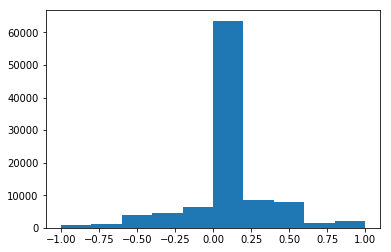

In [79]:
plt.hist(polarity)

In [70]:
sentiment_docs[0]

Sentiment(polarity=0.125, subjectivity=0.16666666666666666)

## Tweets over time

In [16]:
date_group = df.groupby(['date']).count().reset_index()

In [17]:
date_group

,date,_id,coords,datetime,followers,following,hashtags,id,media,media_type,retweets,storm,text,user_id,user_location,user_name,timestamp,weekday
0,2017-08-27,106945,80,106945,4719,4719,106945,106945,14720,14720,106945,106945,106945,88952,4719,88952,106945,106945
1,2017-08-29,627137,298,627137,22654,22654,627137,627137,57172,57172,627137,627137,627137,530703,22654,530703,627137,627137
2,2017-08-30,1465706,783,1465706,53852,53852,1465706,1465706,128284,128284,1465706,1465706,1465706,1256955,53852,1256955,1465706,1465706


In [18]:
date_group['date'] = date_group['date'].apply(str)

In [42]:
#note that there is a file of tweets missing ids that could be used, but it's missing some of the metadata
# missing_df = pd.read_csv('ISCRAM18_datasets/Harvey_missing_ids_50K.csv', sep='\t')
# len(missing_df)

In [19]:
import seaborn as sns

In [20]:
import matplotlib.pyplot as plt

<BarContainer object of 3 artists>

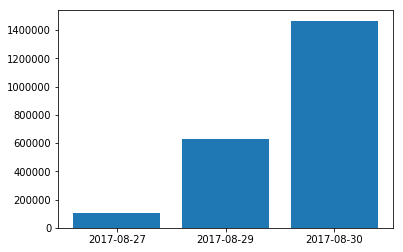

In [22]:
plt.bar(date_group['date'], date_group['id'])

## Sentiment Analysis